# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
    
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)

In [3]:
# Define global functions here, if required

# add random tie breaking to np.argmax function
def random_argmax(b,**kw):
  """ a random tie-breaking argmax"""
  return np.argmax(np.random.random(b.shape) * (b==np.amax(b,**kw, keepdims=True)), **kw)

## 1. Implement ε-greedy and UCB MABs

In [4]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        self.epsilon = epsilon
        self.Q0 = Q0
        # counter for how many times each arm is selected
        self.arm_count = np.zeros(self.n_arms)
        # sum of the reward of different arms
        self.reward_sum = np.zeros(self.n_arms)
    
    def play(self, context=None):
        explore = np.random.binomial(1, self.epsilon)
        # there is epsilon probability to explore new arm
        if explore == 1:
            # select random arm
            return np.random.choice(self.n_arms)
        # otherwise exploit
        else:
            Q = np.full(self.n_arms, self.Q0)
            for i in range(self.n_arms):
                if self.arm_count[i] > 0:
                    Q[i] = self.reward_sum[i]/self.arm_count[i]
            # select the arm with maximum Qt
            return random_argmax(Q)

    def update(self, arm, reward, context=None):
        self.arm_count[arm] += 1
        self.reward_sum[arm] += reward

In [5]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        self.rho = rho
        self.Q0 = Q0
        # counter for how many times each arm is selected
        self.arm_count = np.zeros(self.n_arms)
        # sum of the reward of different arms
        self.reward_sum = np.zeros(self.n_arms)
        # number of round
        self.t = 1
    
    def play(self, context=None):
        Q = np.full(self.n_arms, self.Q0)
        for a in range(self.n_arms):
            if self.arm_count[a] > 0:
                Mu = self.reward_sum[a]/self.arm_count[a]
                explore_degree = np.sqrt((self.rho*np.log(self.t))/self.arm_count[a])
                Q[a] = Mu + explore_degree
        return random_argmax(Q)

        
    def update(self, arm, reward, context=None):
        self.t += 1
        self.arm_count[arm] += 1
        self.reward_sum[arm] += reward

## 2. Implement off-policy evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # list of matching round's reward
    R = []
    # total round number in the dataset
    T = arms.shape[0]
    # a counter for the matching round
    round_count = 0
    for t in range(0, T):
        # process until the end if n_rounds is None
        # otherwise process maximum n_rounds matching rounds
        if n_rounds is not None and round_count == n_rounds:
            break
        if mab.play(contexts[t]) == arms[t]:
            mab.update(arms[t], rewards[t], contexts[t])
            R.append(rewards[t])
            round_count += 1
    return np.array(R)

In [7]:
# load dataset here
arms = []
rewards = []
contexts = []
DIM_NUM = 10

with open('dataset.txt') as dataset:
    for line in dataset:
        str_list = line.split()
        arms.append(str_list[0])
        rewards.append(str_list[1])
        # all the contexts for current round/line
        context_as = []
        for i in range(10):
            start = 2 + i * DIM_NUM
            end = 2 + (i+1)*DIM_NUM
            # the context for a specific arm i
            context_a = str_list[start:end]
            context_as.append(context_a)
        contexts.append(context_as)

arms = np.asarray(arms, dtype=np.int16)
rewards = np.asarray(rewards, dtype=np.float64)
contexts = np.asarray(contexts, dtype=np.float64)

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26625


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.16


## 3. Implement LinUCB contextual MAB

In [10]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        self.n_dims = n_dims
        self.alpha = alpha
        # init n_arms identity matrix with shape n_dims*n_dims
        self.A = np.zeros([n_arms, n_dims, n_dims])
        for k in range(n_arms):
            for m in range(n_dims):
                self.A[k][m][m] = 1
        # init n_arms zero vector with shape n_dims*1
        self.b = np.zeros([n_arms, n_dims, 1])
    
    def play(self, context):
        p = []
        for i in range(self.n_arms):
            A_a = self.A[i]
            theta = np.linalg.inv(A_a).dot(self.b[i])
            x = np.reshape(context[i], [self.n_dims, 1])
            p_a_left = np.matmul(np.transpose(theta), x)
            p_a_right = self.alpha*np.sqrt(np.matmul(np.transpose(x), np.dot(np.linalg.inv(A_a), x)))
            p_a = p_a_left + p_a_right
            p.append(p_a)
        p = np.array(p)
        return random_argmax(p)
    
    def update(self, arm, reward, context):
        x = np.reshape(context[arm], [self.n_dims, 1])
        #  A = A + x.dot(x.T)
        self.A[arm] += np.outer(x, x)
        self.b[arm] += reward*x

In [11]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [12]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        self.n_dims = n_dims
        self.tree = tree
        # history list for the context of observed arm and corresponding reward
        self.D = []
        for i in range(n_arms):
            self.D.append([])
        
    def play(self, context):
        p_hat = np.ones(self.n_arms)
        for a in range(self.n_arms):
            if len(self.D[a]) != 0:
                # Bootstrap
                D_tilde_index = np.random.choice(len(self.D[a]), len(self.D[a]), replace=True)
                D_tilde = []
                for index in D_tilde_index:
                    D_tilde.append(self.D[a][index])
                # split the feature and label
                train_dataset = np.split(D_tilde, [10, 11], axis=1)
                X = train_dataset[0]
                Y = train_dataset[1]
                # train DecisionTreeClassifier
                self.tree.fit(X, Y)
                result = self.tree.predict_proba([context[a]])
                # calculate the expectation of the prediction
                p_hat_a = 0
                for i in range(len(self.tree.classes_)):
                    p_hat_a += self.tree.classes_[i]*result[0][i]
                p_hat[a] = p_hat_a
        return random_argmax(p_hat)


    
    def update(self, arm, reward, context):
        if len(self.D[arm]) == 0:
            self.D[arm].append(np.concatenate((context[arm], [0])))
            self.D[arm].append(np.concatenate((context[arm], [1])))
        self.D[arm].append(np.concatenate((context[arm], [reward])))

In [13]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.685


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

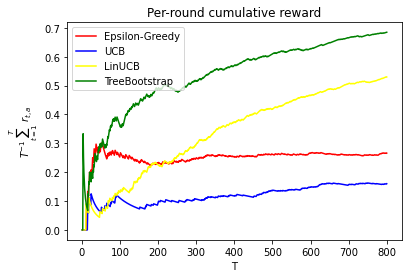

In [14]:
# round list from 1 to 800 with interval 1
time_stamp = np.array(range(1, 801))

# cumulate rewards
cumulative_reward_EpsGreedy = np.cumsum(results_EpsGreedy)
cumulative_reward_UCB = np.cumsum(results_UCB)
cumulative_reward_LinUCB = np.cumsum(results_LinUCB)
cumulative_reward_TreeBootstrap = np.cumsum(results_TreeBootstrap)

plt.plot(time_stamp, cumulative_reward_EpsGreedy/time_stamp, color="red", label="Epsilon-Greedy")
plt.plot(time_stamp,cumulative_reward_UCB/time_stamp, color="blue", label="UCB")
plt.plot(time_stamp,cumulative_reward_LinUCB/time_stamp,color="yellow",label="LinUCB")
plt.plot(time_stamp,cumulative_reward_TreeBootstrap/time_stamp,color="green", label="TreeBootstrap")

plt.legend(loc="upper left", frameon=True)
plt.xlabel("T")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$")
plt.title("Per-round cumulative reward")

plt.show()

### 5.B.

Alpha with the best performance is: 0.02
LinUCB with best alpha average reward 0.73125


Text(0.5, 1.0, 'Grid-search based strategy to select alpha hyperparameter in LinUCB')

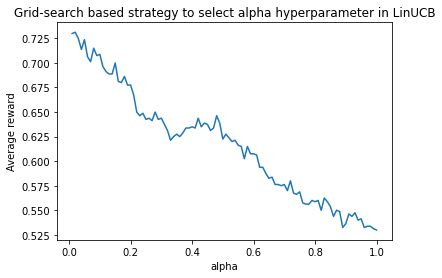

In [15]:
# From the reference https://odr.chalmers.se/bitstream/20.500.12380/256336/1/256336.pdf#page31 chapter 4.1,
# "We notice the average reward for LinUCB is optimal only when alpha is between 0 and 1."
# remove the condition that alpha == 0, as alpha is R+
alphas = np.linspace(0, 1, 101)[1:]
param_tuning_results = []

for alpha in alphas:
    mab = LinUCB(10, 10, alpha)
    param_tuning_results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    param_tuning_results.append(np.mean(param_tuning_results_LinUCB))

best_alpha = alphas[random_argmax(np.array(param_tuning_results))]
print("Alpha with the best performance is: "+str(best_alpha))

# LinUCB with the best alpha
mab = LinUCB(10, 10, best_alpha)
results_LinUCB_with_best_alpha = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB with best alpha average reward', np.mean(results_LinUCB_with_best_alpha))

plt.plot(alphas, param_tuning_results)

plt.xlabel("alpha")
plt.ylabel("Average reward")
plt.title("Grid-search based strategy to select alpha hyperparameter in LinUCB")

## 6. Implement KernelUCB contextual MAB

In [16]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        self.n_dims = n_dims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        # the number of round
        self.n_round = 1
        # the list of the context of selected arm
        self.stored_contexts = []
        # A map for the inverse of K in different round
        self.K_inverse = {}
        # the transpose of reward history y
        self.y_transpose = []
        
    def play(self, context):
        u = np.zeros(self.n_arms)
        if self.n_round == 1:
            u[0] = 1
        else:
            context = np.reshape(context, (self.n_arms,self.n_dims))
            # calculate the k_xa,t_t for all the arms
            # which can save time compared to calculate the k_xa,t_t respectively
            k_x = self.kern(context,np.reshape(self.stored_contexts,(self.n_round-1,self.n_dims)))
            for a in range(self.n_arms):
                # for 1d array, we need to reshape to matrix
                # otherwise, they cannot be transposed
                x_a = context[a].reshape(1, -1)
                sigma_a = np.sqrt(np.abs(self.kern(x_a, x_a)
                                         -np.dot(np.transpose(k_x[a]), np.dot(self.K_inverse[self.n_round], k_x[a]))))
                u_a = np.dot(np.transpose(k_x[a]), np.dot(self.K_inverse[self.n_round], np.transpose(np.reshape(self.y_transpose, (1, -1)))))\
                      +(self.eta/np.sqrt(self.gamma))*sigma_a
                u[a] = u_a
        # choose a random arm with the maximum score
        return random_argmax(u)
    
    def update(self, arm, reward, context):
        self.stored_contexts.append(context[arm].reshape(1, -1))
        self.y_transpose.append(reward)
        x_t = context[arm].reshape(1, -1)
        if self.n_round == 1:
            self.K_inverse[self.n_round+1] = 1/(self.kern(x_t, x_t)+self.gamma)
        else:
            # the transpose of b is equal to [k(x_t, x_1), ...., k(x_t, x_t-1) ]
            b_transpose = []
            for i in range(self.n_round-1):
                b_transpose.append(self.kern(x_t, self.stored_contexts[i].reshape(1, -1)))
            b_transpose = np.array(b_transpose).reshape(1, -1)
            # calculate K11, K12, K21, K22 separately
            K22 = 1/(self.kern(x_t, x_t)+self.gamma-np.dot(b_transpose, np.dot(self.K_inverse[self.n_round], np.transpose(b_transpose))))
            K11 = self.K_inverse[self.n_round] \
                  + K22*np.dot(self.K_inverse[self.n_round], np.dot(np.transpose(b_transpose), np.dot(b_transpose, self.K_inverse[self.n_round])))
            K12 = - K22*np.dot(self.K_inverse[self.n_round], np.transpose(b_transpose))
            K21 = - K22*np.dot(b_transpose, self.K_inverse[self.n_round])
            # reshape K11, K12, K21, K22
            K11 = np.reshape(K11,(self.n_round-1,self.n_round-1))
            K12 = np.reshape(K12,(self.n_round-1,1))
            K21 = np.reshape(K21,(1,self.n_round-1))
            K22 = np.reshape(K22,(1,1))
            # formulate inverse of K_t+1 via K11, K12, K21, K22
            self.K_inverse[self.n_round+1] = np.vstack((np.hstack((K11,K12)),np.hstack((K21,K22))))
        self.n_round += 1

In [17]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.74625


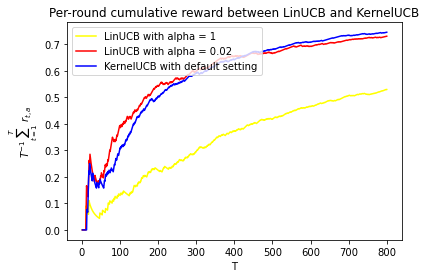

In [18]:
# compare LinUCB and KernelUCB

# cumulate rewards
cumulative_reward_LinUCB_with_best_alpha = np.cumsum(results_LinUCB_with_best_alpha)
cumulative_reward_KernelUCB = np.cumsum(results_KernelUCB)

plt.plot(time_stamp,cumulative_reward_LinUCB/time_stamp,color="yellow",label="LinUCB with alpha = 1")
plt.plot(time_stamp,cumulative_reward_LinUCB_with_best_alpha/time_stamp,color="red",label="LinUCB with alpha = "+str(best_alpha))
plt.plot(time_stamp,cumulative_reward_KernelUCB/time_stamp,color="blue", label="KernelUCB with default setting")

plt.legend(loc="upper left", frameon=True)
plt.xlabel("T")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$")
plt.title("Per-round cumulative reward between LinUCB and KernelUCB")

plt.show()